# A simple linear wave

### Some context
A very basic test problem that also introduces some of the features of the code is to observe the wave transmission of disturbances in the fluid. In other words, if we begin with a constant pressure $P_0$ and density $\rho_0$ fluid, with no velocity $\mathbf{v}=0$, then we can introduce perturbations of the form:

$$
\begin{gathered}
\rho(x,t) = \rho_0 + \delta\rho(x,t) \\
P(x,t) = P_0 + \delta P(x,t) \\
\mathbf{v}(x,t) = \delta\mathbf{v}(x,t)
\end{gathered}
$$

Then, taking the [Euler](https://en.wikipedia.org/wiki/Euler_equations_(fluid_dynamics)#Incompressible_Euler_equations) (with no external forces) and continuity equations, we have (respectively)

$$
\begin{gathered}
\frac{\partial\mathbf{v}}{\partial t} = -\frac{\nabla P}{\rho} \\
\frac{\partial\rho}{\partial t} + \nabla\cdot(\rho\mathbf{v}) = 0
\end{gathered}
$$

Then, linearizing these equations (dropping all second-order and higher terms), assuming $\delta P, \delta \rho << 1$, and taking these two equations together, we get a wave equation for the perturbations

$$\frac{\partial^2 \delta\rho}{\partial t^2} = -\nabla^2\delta P$$

and using an EOS, could express this as a wave equation for each variable. Ultimately, we can see that by specifying the functional form of the density perturbation/disturbance, we can extract initial conditions ($t=0$) for our velocity and pressure perturbations. Explicitly, this means if we take $\delta\rho = A\sin(kx+\omega t)$ (i.e. a sinusoidal disturbance with $k=\omega=2\pi$ and amplitude $A = 10^{-6}$ is induced initially), then we have a corresponding

$$
\begin{gathered}
\delta\mathbf{v}(x,0) = \bigg(\frac{\omega}{k}\bigg)\frac{\rho(x,0)}{\rho_0}\mathbf{\hat{x}} \\
\delta P(x,0) = \bigg(\frac{\omega}{k}\bigg)^2\delta\rho(x,0)
\end{gathered}
$$

If we specify $\rho_0 = 1.0$, $P_0=1$, $\mathbf{v}=0$, and $\gamma = 5/3$ with periodic boundary conditions, then we can see that we have a wave propagating to the right (positive $\mathbf{\hat{x}}$ direction) with velocity 1. This means that after 1 unit of time in the simulation, the wave should propagate through the simulation box and return to its original position – so comparison of the initial and final densities should give us a good indication of the code performance. 

### Using the code
First we need to import the necessary packages. We can import the code via the simple command `import phd`.

In [1]:
import phd
import numpy as np
import unyt as u

Initially, we need to set-up our particle grid. This can be achieved very straightforwardly with some basic code commands. The primary method of doing this is with the `HydroParticleCreator` method, which interfaces with the `CarrayContainer` class to produce a one-dimensional grid of particles of size `n` (in this case, 10) that will later be used to generate the Voronoi mesh. In this method, we also specify the unit system being used for initializing the simulation either by using the ``unit_sys`` (string) or ``unit_dict`` (dictionary) parameters. Our implementation of units makes use of ``yt``'s units package, ``Unyt``. As such, the ``unit_sys`` parameter accepts the name of one of ``unyt``'s built-in unit systems (e.g. cgs, mks, galactic, etc; see [Unyt documentation](https://unyt.readthedocs.io/en/stable/modules/unyt.unit_systems.html#unyt.unit_systems.UnitSystem) for more details). You can also pass your own custom system by specifying the length, mass, and time units in a dictionary and feeding that into the ``unit_dict`` field (note, this will overwrite any use of ``unit_sys``).  

In [2]:
nx = 10   # number of particles in x direction
Lx = 1.    # domain size in x
dx = Lx/nx # spacing between particles
n = nx*nx  # number of points

particles, units = phd.HydroParticleCreator(n, unit_sys = "cgs") # create particle container and specify cgs
units.set_output_system("mks") # sets the simulation output to be in mks unit system

Next, we can specify the initial conditions as outlined above and feed those into the `particles` object just as dictionary key values specified for all particles. Note that we do not feed in unitful quantities here. Instead, we are assuming that all quantities are specified in the unit system defined in the ``HydroParticleCreator`` step.

In [3]:
rho0, vel0, pre0, gamma = 1.0, 0.0, 1.0, 5./3. # density, velocity, pressure initial conditions
A, w, k = 1.0e-6, 2*np.pi, 2*np.pi # amplitude, frequency, wavenumber of sinusoidal perturbation

particles["density"][:] = rho0
particles["velocity-x"][:] = vel0
particles["velocity-y"][:] = 0.0
particles["pressure"][:] = pre0/gamma

Now we can iterate through each of the particles and add the initial perturbation as given above.

In [4]:
for i in range(nx):
    for j in range(nx):
        part = 10*i + j                                        # indexing/counting each of the particles
        x = (i+0.5)*dx; y = (j+0.5)*dx                         # x and y position of the cell
        delta_rho = A*np.sin(k*x)                              # density perturbation (with t=0)
        particles["density"][part] += delta_rho
        particles["velocity-x"][part] += (w/k)*delta_rho/rho0
        particles["pressure"][part] += (w/k)**2*delta_rho

        particles["position-x"][part] = x
        particles["position-y"][part] = y
        particles["ids"][part] = part                          # particle ID

With this in hand, we are ready to initialize our simulation! The following code block establishes the simulation domain via the `DomainManager` class. Next we want to establish the mesh with no regularization and initialize the integration object – here we are simply selecting the integrator that we will use to solve the fluid equations, feeding in each of the components we have defined so far, and setting the Riemann solver `HLLC`. Following that, we establish the stopping criterion for the simulation and dictate that it output the final and initial steps to the screen. Lastly, we name the simulation (this corresponds to the output files that will be stored; here we use `linear_wave_10` to indicate the number of particles) and set the `log_level` to "startup" to suppress some of the output. Omitting this field, or setting it to "info", is recommended for most use cases, though "success", "startup", "debug", "warning", and "info" are all acceptable inputs.

In [5]:
# computation related to boundaries
domain_manager = phd.DomainManager(xmin=[0., 0.], xmax=[1., 1.], initial_radius=0.1)

# create voronoi mesh
mesh = phd.Mesh(regularize=False)

# computation
integrator = phd.MovingMeshMUSCLHancock()
integrator.set_mesh(mesh)
integrator.set_riemann(phd.HLLC())
integrator.set_particles(particles)
integrator.set_domain_manager(domain_manager)
integrator.set_boundary_condition(phd.Periodic())
integrator.set_reconstruction(phd.PieceWiseLinear(gizmo_limiter=False))
integrator.set_equation_state(phd.IdealGas(gamma=gamma))
integrator.set_units(units)

# add finish criteria
simulation_time_manager = phd.SimulationTimeManager()
simulation_time_manager.add_finish(phd.Time(time_max=1.0))

# output last step
output = phd.FinalOutput()
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

# output initial data 
output = phd.InitialOutput()
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

# Create simulator
simulation = phd.Simulation(simulation_name="linear_wave_10", log_level = 'startup')
simulation.set_integrator(integrator)
simulation.set_simulation_time_manager(simulation_time_manager)
simulation.initialize()
simulation.solve()

phd: [WARNING  ] 2021-07-28 11:36:25,220: Directory linear_wave_10_output already exists, files maybe over written!
phd: [WARNING  ] 2021-07-28 11:36:25,223: Directory linear_wave_10_output/final_output already exists, files maybe over written!
phd: [WARNING  ] 2021-07-28 11:36:25,224: Directory linear_wave_10_output/initial_output already exists, files maybe over written!
phd: [STARTUP  ] 2021-07-28 11:36:25,226: 

 __________.__         .___
\______   \  |__    __| _/
 |     ___/  |  \  / __ |
 |    |   |   Y  \/ /_/ |
 |____|   |___|  /\____ |
               \/      \/
Welcome to Python Hydro-Dynamics!

Simulation Information
------------------------------
Running in serial
Log file saved at: linear_wave_10.log
Problem solving: linear_wave_10
Output data will be saved at: linear_wave_10_output

Classes used in the simulation
------------------------------
boundary_condition: Periodic
domain_manager: DomainManager
equation_state: IdealGas
integrator: MovingMeshMUSCLHancock
mesh: Mesh

To visualize the results, we can extract the data from the initial and final output files, plotting the density on the upper left, and the pressures, densities, and velocities in the other three panels. To read the data we use ``phd``'s Hdf5 reader, which is built to extract the relevant particle data and simulation attributes from the output files. In particular, use of ``phd.Hdf5().read(file_name)`` returns the particle data at that snapshot of the simulation and the unit object associated with the simulation output. We can then plot the results, in-line converting the expected range of values from cgs to mks units so that the results can be viewed in the output system that we specified at the start.

Comparing the initial (x's) and final (o's) values, we can see some slight discrepancy, which improves as we increase the grid resolution (i.e. increase `nx`), with convergence that is approximately second-order. Extrapolating to higher resolutions is a simple extension of the above procedure and can be functionally achieved by locally defining a method to create particles and looping through different resolutions.

phd: [INFO     ] 2021-07-21 12:03:34,553: hdf5 format: Reading filename ./linear_wave_10_output/initial_output/initial_output0000/initial_output0000.hdf5
phd: [INFO     ] 2021-07-21 12:03:34,567: hdf5 format: Reading filename ./linear_wave_10_output/final_output/final_output0000/final_output0000.hdf5


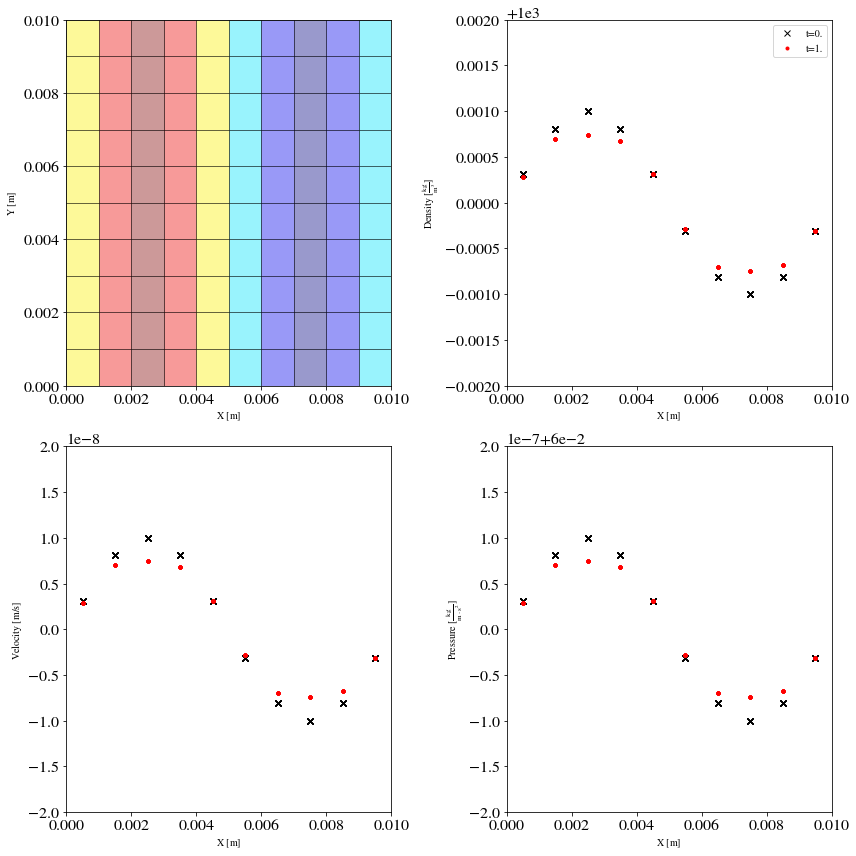

In [6]:
# For plotting...
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
%matplotlib inline

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["xtick.labelsize"] = 16
mpl.rcParams["ytick.labelsize"] = 16


path_to_output = './'
init_output = path_to_output + 'linear_wave_10_output/initial_output/initial_output0000/initial_output0000.hdf5'
final_output = path_to_output + 'linear_wave_10_output/final_output/final_output0000/final_output0000.hdf5'

reader = phd.Hdf5()
init_particles, units = reader.read(init_output)
final_particles, units = reader.read(final_output)

# extracting the output units of the simulation
len_unit = units.get_bases()['length']
vel_unit = units.get_bases()['velocity']
time_unit = units.get_bases()['time']
mass_unit = units.get_bases()['mass']
dens_unit = units.get_bases()['density']
press_unit = units.get_bases()['pressure']

fig, axes = plt.subplots(2,2, figsize=(12,12))

fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.8)

patch, colors = phd.vor_collection(init_particles, "density")
init_particles.remove_tagged_particles(phd.ParticleTAGS.Ghost)
final_particles.remove_tagged_particles(phd.ParticleTAGS.Ghost)

p = PatchCollection(patch, cmap="jet", edgecolor="black", alpha=0.4)
p.set_array(np.array(colors))
ax = axes[0,0]
ax.set_xlabel(f"X [${len_unit.latex_repr}$]")
ax.set_ylabel(f"Y [${len_unit.latex_repr}$]")
ax.set_xlim(0,(1*u.cm).to(len_unit))
ax.set_ylim(0,(1*u.cm).to(len_unit))
ax.add_collection(p)

ax = axes[0,1]
ax.plot(init_particles["position-x"], init_particles["density"], "kx", label="t=0.")
ax.plot(final_particles["position-x"], final_particles["density"], "r.", label="t=1.")
ax.set_xlim(0,(1.0*u.cm).to(len_unit))
ax.set_ylim(((1.0-2.0e-6)*u.g/u.cm**3).to(dens_unit),((1.0+2.0e-6)*u.g/u.cm**3).to(dens_unit))
ax.set_xlabel(f"X [${len_unit.latex_repr}$]")
ax.set_ylabel(f"Density [${dens_unit.latex_repr}$]")
ax.legend()

ax = axes[1,0]
ax.plot(init_particles["position-x"], init_particles["velocity-x"], "kx", label="t=0.")
ax.plot(final_particles["position-x"], final_particles["velocity-x"], "r.", label="t=1.")
ax.set_xlim(0,(1.0*u.cm).to(len_unit))
ax.set_ylim((-2.0e-6*u.cm/u.s).to(vel_unit),(2.0e-6*u.cm/u.s).to(vel_unit))
ax.set_xlabel(f"X [${len_unit.latex_repr}$]")
ax.set_ylabel(f"Velocity [${vel_unit.latex_repr}$]")

ax = axes[1,1]
ax.plot(init_particles["position-x"], init_particles["pressure"], "kx", label="t=0")
ax.plot(final_particles["position-x"], final_particles["pressure"], "r.", label="t=1")
ax.set_xlim(0,(1*u.cm).to(len_unit))
ax.set_ylim(((3./5.-2.0e-6)*u.dyn/u.cm**2).to(press_unit),((3.0/5.+2.0e-6)*u.dyn/u.cm**2).to(press_unit))
ax.set_xlabel(f"X [${len_unit.latex_repr}$]")
ax.set_ylabel(f"Pressure [${press_unit.latex_repr}$]")

plt.tight_layout()
plt.savefig('linear_wave_plot.png')
plt.show()